# Statistics Under the Stars Hackathon (SUS7)
This is the solution produced by the team "The ImBrutiti" for the Statistics Under the Stars (SUS7) hackathon, organized by y-SIS (Statistical Society of Italy) by the University of Salento at Lecce. Italy and sponsored by Adecco.  

Our team, composed of Gianluca Procopio, Giorgio Bertone, Filippo Parlanti and Himel Ghosh, reached the 2nd place and received the "Best Objective Prediction" award.

In [28]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from geopy.distance import geodesic
from geopy.geocoders import Nominatim
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from math import radians, sin, cos, sqrt, atan2
from tensorflow.keras.callbacks import EarlyStopping

np.random.seed(42)

In [30]:
# Import job position datasets
job_positions_train=pd.read_csv("job_positions_train.csv")
job_positions_test=pd.read_csv("job_positions_test.csv")
# Import candidates datasets
candidates_train=pd.read_csv("candidates_train.csv")
candidates_test=pd.read_csv("candidates_test.csv")


Quick look to how the dataset we are dealing with looks like.

In [32]:
job_positions_train

,Job_ID,Prof_cat,Hard_skills_group,Soft_skills,Education,Languages,Cards,Work_city,Latitudine,Longitudine
0,1739_114,addetto agli scaffali/addetta agli scafali,Grande distribuzione,Orientamento al cliente;Orientamento al risultato,NaN,NaN,NaN,PIOLTELLO,45.5050,9.33151
1,1606_139,addetto agli scaffali/addetta agli scafali,Grande distribuzione,Pianificazione e organizzazione,NaN,NaN,B,MILANO,45.4773,9.18150
2,1636_143,addetto agli scaffali/addetta agli scafali,Contact Center;Vendita;Segreteria,Decision Making;Team Working;Gestione dei camb...,NaN,NaN,NaN,MILANO,45.4773,9.18150
3,1739_397,addetto agli scaffali/addetta agli scafali,Vendita,NaN,NaN,NaN,B,PIOLTELLO,45.5050,9.33151
4,1739_405,addetto agli scaffali/addetta agli scafali,Vendita,NaN,NaN,NaN,B,PIOLTELLO,45.5050,9.33151
...,...,...,...,...,...,...,...,...,...,...
2526,0264_24098,segretario/segretaria,Acquisti;Fogli di calcolo / elettronici;Word P...,Problem solving e analisi;Comunicazione;Team W...,NaN,Inglese,NaN,BARASSO,45.8405,8.75683
2527,0300_24353,segretario/segretaria,Word Processor - Elaborazione testi;Vendita;Ba...,Decision Making;Problem solving e analisi;Orie...,NaN,Inglese,B,SANTA MARIA A MONTE,43.6999,10.68900
2528,0044_24693,segretario/segretaria,Segreteria;Fogli di calcolo / elettronici,Problem solving e analisi;Orientamento alla qu...,NaN,NaN,B,CAORSO,45.0485,9.87107
2529,0016_27490,segretario/segretaria,Fogli di calcolo / elettronici;Animazione e sp...,Comunicazione;Decision Making;Pianificazione e...,NaN,Inglese,NaN,TRENTO,46.0679,11.12110


Since attributes like "Soft Skill", "Hard Skill" and "Prof_cat" contain a list of string separated by semicolon, we need to represent them in another way.   
Therefore we first transformed them into a set of string by splitting on semicolons.

In [33]:
# Convert lists into sets for easier processing
def convert_to_set(column):
    return column.apply(lambda x: set(x.split(';')) if x else set())

In [34]:
# DATASET JOB_POSITION
# Train
# remove NaN field
job_positions_train.fillna('', inplace=True)
job_positions_train['Hard_skills_group'] = convert_to_set(job_positions_train['Hard_skills_group'])
job_positions_train['Soft_skills'] = convert_to_set(job_positions_train['Soft_skills'])
job_positions_train['Languages'] = convert_to_set(job_positions_train['Languages'])
job_positions_train['Cards'] = convert_to_set(job_positions_train['Cards'])
job_positions_train['Education'] = convert_to_set(job_positions_train['Education'])

# Test
# remove NaN field
job_positions_test.fillna('', inplace=True)
job_positions_test['Hard_skills_group'] = convert_to_set(job_positions_test['Hard_skills_group'])
job_positions_test['Soft_skills'] = convert_to_set(job_positions_test['Soft_skills'])
job_positions_test['Languages'] = convert_to_set(job_positions_test['Languages'])
job_positions_test['Cards'] = convert_to_set(job_positions_test['Cards'])
job_positions_test['Education'] = convert_to_set(job_positions_test['Education'])

In [36]:
job_positions_train

,Job_ID,Prof_cat,Hard_skills_group,Soft_skills,Education,Languages,Cards,Work_city,Latitudine,Longitudine
0,1739_114,addetto agli scaffali/addetta agli scafali,{Grande distribuzione},"{Orientamento al cliente, Orientamento al risu...",{},{},{},PIOLTELLO,45.505,9.33151
1,1606_139,addetto agli scaffali/addetta agli scafali,{Grande distribuzione},{Pianificazione e organizzazione},{},{},{B},MILANO,45.4773,9.1815
2,1636_143,addetto agli scaffali/addetta agli scafali,"{Vendita, Segreteria, Contact Center}","{Gestione dei cambiamenti, Decision Making, Te...",{},{},{},MILANO,45.4773,9.1815
3,1739_397,addetto agli scaffali/addetta agli scafali,{Vendita},{},{},{},{B},PIOLTELLO,45.505,9.33151
4,1739_405,addetto agli scaffali/addetta agli scafali,{Vendita},{},{},{},{B},PIOLTELLO,45.505,9.33151
...,...,...,...,...,...,...,...,...,...,...
2526,0264_24098,segretario/segretaria,"{Word Processor - Elaborazione testi, Vendita,...","{Orientamento alla qualità, Problem solving e ...",{},{Inglese},{},BARASSO,45.8405,8.75683
2527,0300_24353,segretario/segretaria,"{Word Processor - Elaborazione testi, Vendita,...","{Problem solving e analisi, Orientamento alla ...",{},{Inglese},{B},SANTA MARIA A MONTE,43.6999,10.689
2528,0044_24693,segretario/segretaria,"{Segreteria, Fogli di calcolo / elettronici}","{Problem solving e analisi, Orientamento alla ...",{},{},{B},CAORSO,45.0485,9.87107
2529,0016_27490,segretario/segretaria,"{Word Processor - Elaborazione testi, Progetta...","{Orientamento alla qualità, Problem solving e ...",{},{Inglese},{},TRENTO,46.0679,11.1211


In [37]:
# DATASET CANDIDATES
# Train
# Fill missing values with empty strings
candidates_train.fillna('', inplace=True)

candidates_train['Prof_cat_exp'] = convert_to_set(candidates_train['Prof_cat_exp'])
candidates_train['Prof_cat_int'] = convert_to_set(candidates_train['Prof_cat_int'])
candidates_train['Hard_skills_group'] = convert_to_set(candidates_train['Hard_skills_group'])
candidates_train['Soft_skills'] = convert_to_set(candidates_train['Soft_skills'])
candidates_train['Languages'] = convert_to_set(candidates_train['Languages'])
candidates_train['Cards'] = convert_to_set(candidates_train['Cards'])
candidates_train['Education']=convert_to_set(candidates_train['Education'])

# Test
# Fill missing values with empty strings
candidates_test.fillna('', inplace=True)

candidates_test['Prof_cat_exp'] = convert_to_set(candidates_test['Prof_cat_exp'])
candidates_test['Prof_cat_int'] = convert_to_set(candidates_test['Prof_cat_int'])
candidates_test['Hard_skills_group'] = convert_to_set(candidates_test['Hard_skills_group'])
candidates_test['Soft_skills'] = convert_to_set(candidates_test['Soft_skills'])
candidates_test['Languages'] = convert_to_set(candidates_test['Languages'])
candidates_test['Cards'] = convert_to_set(candidates_test['Cards'])
candidates_test['Education']=convert_to_set(candidates_test['Education'])

Then we noticed that the Education column was really bad formatted, therefore we tried to map the Candidate's Education fields to the 4 different categories in the job Education field ('Diploma / Accademia', 'Istituto Tecnico Superiore (ITS)', 'Laurea Magistrale', 'Laurea Triennale', 'Qualifica / Attestato'), but we merged 'Diploma / Accademia' and 'Qualifica / Attestato' into the category 'Other'.

In [ ]:
# Job Education has:
# ['Diploma / Accademia', 'Istituto Tecnico Superiore (ITS)', 'Laurea Magistrale', 'Laurea Triennale', 'Qualifica / Attestato']

## Education Mapping
# Containing word ITS --> 'Istituto Tecnico Superiore (ITS)'
# Containing (L-##) --> 'Laurea Triennale'
# Containing (LM-##) --> 'Laurea Magistrale'
# Other things --> 'Other'
def map_education(edu):
    edu_set = set(edu)
    out = set()
    for x in edu_set:
        if 'ITS' in x:
            out.add('Istituto Tecnico Superiore (ITS)')
        elif '(L-' in x:
            out.add('Laurea Triennale')
        elif '(LM-' in x:
            out.add('Laurea Magistrale')
        else:
            out.add('Other')
    return {x for x in out}

## Remap 'Diploma / Accademia' and 'Qualifica / Attestato' of Job Education to 'Other'
def remap_education_job(edu):
    edu_set = set(edu)
    out = set()
    for x in edu_set:
        if 'Diploma / Accademia' in edu:
            out.add('Other')
        elif 'Qualifica / Attestato' in edu:
            out.add('Other')
    return {x for x in out}

In [38]:
# Education Mapping
candidates_test['Education'] = candidates_test['Education'].apply(lambda x: map_education(x))
job_positions_train['Education'] = job_positions_train['Education'].apply(lambda x: remap_education_job(x))
candidates_train['Education'] = candidates_train['Education'].apply(lambda x: map_education(x))

To properly deal with 'Hard Skills', 'Soft Skills', 'Languages', 'Cards' and 'Education', once trasformed from string into set, we extracted the combined list of all the single element for each feature and we created a binary matrix by taking advantage of the MultiLabelBinarizer() from the scikitlearn library.  

In the end we will get all the features encoded through a binary matrix.

In [ ]:
# Combine data from both job positions and candidates for fitting
all_hard_skills = pd.concat([job_positions_train['Hard_skills_group'], candidates_train['Hard_skills_group']])
all_soft_skills = pd.concat([job_positions_train['Soft_skills'], candidates_train['Soft_skills']])
all_languages = pd.concat([job_positions_train['Languages'], candidates_train['Languages']])
all_cards = pd.concat([job_positions_train['Cards'], candidates_train['Cards']])
all_edu = pd.concat([job_positions_train['Education'], candidates_train['Education']])

# Combine data from both job positions and candidates for fitting
all_hard_skills_t = pd.concat([job_positions_test['Hard_skills_group'], candidates_test['Hard_skills_group']])
all_soft_skills_t = pd.concat([job_positions_test['Soft_skills'], candidates_test['Soft_skills']])
all_languages_t = pd.concat([job_positions_test['Languages'], candidates_test['Languages']])
all_cards_t = pd.concat([job_positions_test['Cards'], candidates_test['Cards']])
all_edu_t = pd.concat([job_positions_test['Education'], candidates_test['Education']])

Use the MultiLabelBinarizer() to encode the features.

In [ ]:
# Initialize MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Fit MultiLabelBinarizer on combined data
mlb.fit(all_hard_skills)
job_positions_hard_skills = pd.DataFrame(mlb.transform(job_positions_train['Hard_skills_group']), columns=mlb.classes_)
candidates_hard_skills = pd.DataFrame(mlb.transform(candidates_train['Hard_skills_group']), columns=mlb.classes_)

# Fit MultiLabelBinarizer on combined data
job_positions_hard_skills_t = pd.DataFrame(mlb.transform(job_positions_test['Hard_skills_group']), columns=mlb.classes_)
candidates_hard_skills_t = pd.DataFrame(mlb.transform(candidates_test['Hard_skills_group']), columns=mlb.classes_)


mlb.fit(all_soft_skills)
job_positions_soft_skills = pd.DataFrame(mlb.transform(job_positions_train['Soft_skills']), columns=mlb.classes_)
candidates_soft_skills = pd.DataFrame(mlb.transform(candidates_train['Soft_skills']), columns=mlb.classes_)

job_positions_soft_skills_t = pd.DataFrame(mlb.transform(job_positions_test['Soft_skills']), columns=mlb.classes_)
candidates_soft_skills_t = pd.DataFrame(mlb.transform(candidates_test['Soft_skills']), columns=mlb.classes_)


mlb.fit(all_languages)
job_positions_languages = pd.DataFrame(mlb.transform(job_positions_train['Languages']), columns=mlb.classes_)
candidates_languages = pd.DataFrame(mlb.transform(candidates_train['Languages']), columns=mlb.classes_)

job_positions_languages_t = pd.DataFrame(mlb.transform(job_positions_test['Languages']), columns=mlb.classes_)
candidates_languages_t = pd.DataFrame(mlb.transform(candidates_test['Languages']), columns=mlb.classes_)


mlb.fit(all_cards)
job_positions_cards = pd.DataFrame(mlb.transform(job_positions_train['Cards']), columns=mlb.classes_)
candidates_cards = pd.DataFrame(mlb.transform(candidates_train['Cards']), columns=mlb.classes_)

job_positions_cards_t = pd.DataFrame(mlb.transform(job_positions_test['Cards']), columns=mlb.classes_)
candidates_cards_t = pd.DataFrame(mlb.transform(candidates_test['Cards']), columns=mlb.classes_)


mlb.fit(all_edu)
job_positions_edu = pd.DataFrame(mlb.transform(job_positions_train['Education']), columns=mlb.classes_)
candidates_edu = pd.DataFrame(mlb.transform(candidates_train['Education']), columns=mlb.classes_)

job_positions_edu_t = pd.DataFrame(mlb.transform(job_positions_test['Education']), columns=mlb.classes_)
candidates_edu_t = pd.DataFrame(mlb.transform(candidates_test['Education']), columns=mlb.classes_)

Then we created another dataset by dropping the old features and we substitutes them with the encoded one.

In [ ]:
# Merge the encoded features back into the original DataFrames
job_positions_train_encoded = pd.concat([job_positions_train.drop(['Hard_skills_group', 'Soft_skills', 'Languages', 'Cards','Education'], axis=1), 
                                         job_positions_hard_skills, job_positions_soft_skills, job_positions_languages, job_positions_cards,job_positions_edu], axis=1)

candidates_train_encoded = pd.concat([candidates_train.drop(['Hard_skills_group', 'Soft_skills', 'Languages', 'Cards','Education'], axis=1), 
                                      candidates_hard_skills, candidates_soft_skills, candidates_languages, candidates_cards,candidates_edu], axis=1)

# Merge the encoded features back into the original DataFrames
job_positions_test_encoded = pd.concat([job_positions_test.drop(['Hard_skills_group', 'Soft_skills', 'Languages', 'Cards','Education'], axis=1), 
                                         job_positions_hard_skills_t, job_positions_soft_skills_t, job_positions_languages_t, job_positions_cards_t, job_positions_edu_t], axis=1)

candidates_test_encoded = pd.concat([candidates_test.drop(['Hard_skills_group', 'Soft_skills', 'Languages', 'Cards','Education'], axis=1), 
                                      candidates_hard_skills_t, candidates_soft_skills_t, candidates_languages_t, candidates_cards_t, candidates_edu_t], axis=1)

Now we needed to create another dataset, since after the encoding we have a lot of features. To create such dataset we decided to compute similaritites among features, in particular we took advantage of Jaccard and Cosine similarity.

In [51]:
# Function to calculate Jaccard similarity
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    if union == 0:
        return 0
    return intersection / union

# Calculate similarity features for a row
def calculate_similarity_features(row, candidates_df, jobs_df):
    candidate_id = row['CANDIDATE_ID']
    job_id = row['Job_ID']
    
    candidate = candidates_df[candidates_df['CANDIDATE_ID'] == candidate_id].iloc[0]
    job = jobs_df[jobs_df['Job_ID'] == job_id].iloc[0]
    
    features = {}
    features['prof_cat_exp_similarity'] = jaccard_similarity(candidate['Prof_cat_exp'], set([job['Prof_cat']]))
    features['prof_cat_int_similarity'] = jaccard_similarity(candidate['Prof_cat_int'], set([job['Prof_cat']]))
    features['hard_skills_similarity'] = cosine_similarity([candidate[hard_skills_columns].values], [job[hard_skills_columns].values])[0][0]
    features['soft_skills_similarity'] = cosine_similarity([candidate[soft_skills_columns].values], [job[soft_skills_columns].values])[0][0]
    features['languages_similarity'] = cosine_similarity([candidate[languages_columns].values], [job[languages_columns].values])[0][0]
    features['cards_similarity'] = cosine_similarity([candidate[cards_columns].values], [job[cards_columns].values])[0][0]
    features['Education_similarity'] = cosine_similarity([candidate[education_columns].values], [job[education_columns].values])[0][0]
    
    # Combine feature vectors for overall similarity
    candidate_vector = candidate[hard_skills_columns].tolist() + \
                       candidate[soft_skills_columns].tolist() + \
                       candidate[languages_columns].tolist() + \
                       candidate[cards_columns].tolist()
    
    job_vector = job[hard_skills_columns].tolist() + \
                 job[soft_skills_columns].tolist() + \
                 job[languages_columns].tolist() + \
                 job[cards_columns].tolist()
    features['overall_similarity'] = cosine_similarity([candidate_vector], [job_vector])[0][0]

    
    return pd.Series(features)

# Columns to calculate cosine similarity
hard_skills_columns = candidates_hard_skills.columns
soft_skills_columns = candidates_soft_skills.columns
languages_columns = candidates_languages.columns
cards_columns = candidates_cards.columns
education_columns=candidates_edu.columns

Now that all our preprocessing is done, we need to create the final dataset. We have been given of a third dataset, called 'matches', which contains a job id, a candidate id and the flag 0/1 whether that candidate has or hasn't gotten the job. 

Notice that for each job there are 5 candidates but just 1 of them can be selected, but the same candidate may be selected for more than one job.

In [53]:
matches_train = pd.read_csv('matches_train.csv')
matches_test = pd.read_csv('matches_test.csv')

This is how the matches dataset looks like:

In [54]:
matches_train

,Job_ID,CANDIDATE_ID,Match
0,0264_22927,1933502,1
1,0553_22671,6016478,1
2,1354_730,6167354,1
3,1526_995,5883294,1
4,0130_11963,5848616,1
...,...,...,...
12650,0178_21171,5011230,0
12651,0070_20302,2214010,0
12652,0349_15070,7638353,0
12653,0509_16576,3451059,0


Our final dataset is based on the similarity among the features of the candidates and of the job position, which are then joined thanks to the 'matches' dataset.

In [55]:
# Calculate similarity features
similarity_features = matches_train.apply(lambda row: calculate_similarity_features(row, candidates_train_encoded, job_positions_train_encoded), axis=1)
matches_train = matches_train.join(similarity_features)

similarity_features = matches_test.apply(lambda row: calculate_similarity_features(row, candidates_test_encoded, job_positions_test_encoded), axis=1)
matches_test = matches_test.join(similarity_features)

This is how our new dataset looks like

In [56]:
matches_train

,Job_ID,CANDIDATE_ID,Match,prof_cat_exp_similarity,prof_cat_int_similarity,hard_skills_similarity,soft_skills_similarity,languages_similarity,cards_similarity,Education_similarity,overall_similarity
0,0264_22927,1933502,1,1.000000,0.0,0.0,0.000000,0.000000,1.0,0.0,0.258199
1,0553_22671,6016478,1,1.000000,0.5,0.0,0.000000,0.000000,0.0,0.0,0.000000
2,1354_730,6167354,1,1.000000,1.0,1.0,0.000000,0.000000,0.0,0.0,0.577350
3,1526_995,5883294,1,1.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
4,0130_11963,5848616,1,1.000000,0.5,0.0,0.000000,0.000000,1.0,0.0,0.176777
...,...,...,...,...,...,...,...,...,...,...,...
12650,0178_21171,5011230,0,0.500000,0.0,0.0,0.816497,0.000000,0.0,0.0,0.239046
12651,0070_20302,2214010,0,0.333333,0.0,0.5,0.447214,0.707107,0.0,0.0,0.400892
12652,0349_15070,7638353,0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
12653,0509_16576,3451059,0,0.000000,0.0,0.0,0.577350,0.000000,0.0,0.0,0.204124


In [57]:
matches_train[matches_train.Job_ID == '0264_22927']

,Job_ID,CANDIDATE_ID,Match,prof_cat_exp_similarity,prof_cat_int_similarity,hard_skills_similarity,soft_skills_similarity,languages_similarity,cards_similarity,Education_similarity,overall_similarity
0,0264_22927,1933502,1,1.000000,0.0,0.0,0.0,0.0,1.000000,0.0,0.258199
9274,0264_22927,2968728,0,0.333333,0.0,0.0,0.0,0.0,0.707107,0.0,0.149071
9550,0264_22927,2643665,0,0.000000,0.0,0.0,0.0,0.0,1.000000,0.0,0.223607
10882,0264_22927,1216748,0,0.000000,0.0,0.0,0.0,0.0,1.000000,0.0,0.169031
11113,0264_22927,1441537,0,0.000000,0.0,0.0,0.0,0.0,0.707107,0.0,0.149071


In [58]:
matches_test

,Match,Job_ID,CANDIDATE_ID,prof_cat_exp_similarity,prof_cat_int_similarity,hard_skills_similarity,soft_skills_similarity,languages_similarity,cards_similarity,Education_similarity,overall_similarity
0,NaN,1014_514,23262979,1.00,0.333333,0.408248,0.0,1.000000,0.000000,0.0,0.316228
1,NaN,1014_514,1482016,0.25,0.000000,0.000000,0.0,0.707107,0.000000,0.0,0.182574
2,NaN,1014_514,83352824,0.50,0.333333,1.000000,0.0,0.000000,0.000000,0.0,0.316228
3,NaN,1014_514,54602123,1.00,1.000000,0.408248,0.0,1.000000,0.000000,0.0,0.298142
4,NaN,1014_514,92641837,0.25,0.000000,0.000000,0.0,0.577350,0.000000,0.0,0.134840
...,...,...,...,...,...,...,...,...,...,...,...
3995,NaN,9996_273,82724002,0.00,0.000000,0.365148,0.0,0.000000,0.707107,0.0,0.327327
3996,NaN,9996_273,38957146,0.00,0.200000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
3997,NaN,9996_273,5137608,0.00,0.000000,0.000000,0.0,0.000000,1.000000,0.0,0.166667
3998,NaN,9996_273,39393438,0.00,0.000000,0.000000,0.0,0.000000,0.707107,0.0,0.235702


We also noticed that 'Latitudine' and 'Longitudine' have missing values, therefore we imputed them by scraping the coordinates of the city of the missing entries.

In [59]:
# Initialize the Nominatim geocoder
geolocator = Nominatim(user_agent="geoapiExercises")

# Function to get latitude and longitude
def get_lat_lon(city_name):
    location = geolocator.geocode(city_name)
    if location:
        return location.latitude, location.longitude
    else:
        return None, None

Impute missing values:

In [60]:
# Iterate through the DataFrame and update missing values
for idx, row in candidates_train.iterrows():
    if row['Latitudine'] == '' or row['Longitudine'] == '':
        city = row['Domicile_City']
        latitude, longitude = get_lat_lon(city)
        candidates_train.at[idx, 'Latitudine'] = latitude
        candidates_train.at[idx, 'Longitudine'] = longitude
        # Pause for a moment to respect the usage policy of the geocoding service
        time.sleep(1)

for idx, row in job_positions_train.iterrows():
    if row['Latitudine'] == '' or row['Longitudine'] == '':
        city = row['Work_city']
        latitude, longitude = get_lat_lon(city)
        job_positions_train.at[idx, 'Latitudine'] = latitude
        job_positions_train.at[idx, 'Longitudine'] = longitude
        # Pause for a moment to respect the usage policy of the geocoding service
        time.sleep(1)

In [61]:
# Iterate through the DataFrame and update missing values
for idx, row in candidates_test.iterrows():
    if row['Latitudine'] == '' or row['Longitudine'] == '':
        city = row['Domicile_City']
        latitude, longitude = get_lat_lon(city)
        candidates_test.at[idx, 'Latitudine'] = latitude
        candidates_test.at[idx, 'Longitudine'] = longitude
        # Pause for a moment to respect the usage policy of the geocoding service
        time.sleep(1)

for idx, row in job_positions_test.iterrows():
    if row['Latitudine'] == '' or row['Longitudine'] == '':
        city = row['Work_city']
        latitude, longitude = get_lat_lon(city)
        job_positions_test.at[idx, 'Latitudine'] = latitude
        job_positions_test.at[idx, 'Longitudine'] = longitude
        # Pause for a moment to respect the usage policy of the geocoding service
        time.sleep(1)

Add latitude and longitude to our dataset

In [62]:
cand_to_merge = candidates_train[['CANDIDATE_ID', 'Latitudine', 'Longitudine']]
job_to_merge = job_positions_train[['Job_ID', 'Latitudine', 'Longitudine']]

cand_to_merge_test = candidates_test[['CANDIDATE_ID', 'Latitudine', 'Longitudine']]
job_to_merge_test = job_positions_test[['Job_ID', 'Latitudine', 'Longitudine']]

matches_train_d = matches_train.merge(cand_to_merge, on='CANDIDATE_ID', how='left').merge(job_to_merge, on='Job_ID', how='left')
matches_test_d = matches_test.merge(cand_to_merge_test, on='CANDIDATE_ID', how='left').merge(job_to_merge_test, on='Job_ID', how='left')

To compute the distance between the Candidate city and the Job city we took advantage of the following function that allowed us to compute the circle distance in kilometers between two points on the earth.

In [63]:
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    lat1 = float(lat1)
    lon1 = float(lon1)
    lat2 = float(lat2)
    lon2 = float(lon2)
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    # Radius of the Earth in kilometers
    R = 6371.0
    
    # Calculate the distance
    distance = R * c
    
    return distance

Compute such distances

In [64]:
matches_train['distance'] = matches_train_d.apply(lambda row: haversine(row['Latitudine_x'], row['Longitudine_x'], row['Latitudine_y'], row['Longitudine_y']), axis=1)
matches_test['distance'] = matches_test_d.apply(lambda row: haversine(row['Latitudine_x'], row['Longitudine_x'], row['Latitudine_y'], row['Longitudine_y']), axis=1)

In [65]:
matches_train

,Job_ID,CANDIDATE_ID,Match,prof_cat_exp_similarity,prof_cat_int_similarity,hard_skills_similarity,soft_skills_similarity,languages_similarity,cards_similarity,Education_similarity,overall_similarity,distance
0,0264_22927,1933502,1,1.000000,0.0,0.0,0.000000,0.000000,1.0,0.0,0.258199,2.132456
1,0553_22671,6016478,1,1.000000,0.5,0.0,0.000000,0.000000,0.0,0.0,0.000000,8.767585
2,1354_730,6167354,1,1.000000,1.0,1.0,0.000000,0.000000,0.0,0.0,0.577350,6.301685
3,1526_995,5883294,1,1.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,16.536885
4,0130_11963,5848616,1,1.000000,0.5,0.0,0.000000,0.000000,1.0,0.0,0.176777,6.732852
...,...,...,...,...,...,...,...,...,...,...,...,...
12650,0178_21171,5011230,0,0.500000,0.0,0.0,0.816497,0.000000,0.0,0.0,0.239046,29.687561
12651,0070_20302,2214010,0,0.333333,0.0,0.5,0.447214,0.707107,0.0,0.0,0.400892,25.380609
12652,0349_15070,7638353,0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,9.991345
12653,0509_16576,3451059,0,0.000000,0.0,0.0,0.577350,0.000000,0.0,0.0,0.204124,12.046100


Add also the squared distance, to have more features.

In [66]:
matches_train['distance2'] = matches_train['distance']**2
matches_test['distance2'] = matches_test['distance']**2

Of course we need to scale our data to get a better representation and improve our future models.

In [67]:
# Initialize StandardScaler
scaler = StandardScaler()

features_to_scale = ['prof_cat_exp_similarity', 'prof_cat_int_similarity', 
                     'hard_skills_similarity', 'soft_skills_similarity', 'languages_similarity', 'cards_similarity',
                     'distance', 'Education_similarity', 'overall_similarity', 'distance2']

# Scale the dataset
scaled_data = scaler.fit_transform(matches_train[features_to_scale])

scaled_data_test = scaler.fit_transform(matches_test[features_to_scale])

# Convert to DataFrame for readability
scaled_df = pd.DataFrame(scaled_data, columns=matches_train[features_to_scale].columns)
scaled_df_test = pd.DataFrame(scaled_data_test, columns=matches_test[features_to_scale].columns)

matches_train_scaled = pd.concat([matches_train.drop(features_to_scale, axis=1), scaled_df], axis=1)
matches_test_scaled = pd.concat([matches_test.drop(features_to_scale, axis=1), scaled_df_test], axis=1)

Quick look to how the scaled dataset looks like

In [68]:
matches_train_scaled

,Job_ID,CANDIDATE_ID,Match,prof_cat_exp_similarity,prof_cat_int_similarity,hard_skills_similarity,soft_skills_similarity,languages_similarity,cards_similarity,distance,Education_similarity,overall_similarity,distance2
0,0264_22927,1933502,1,1.792094,-0.592272,-0.572167,-0.516798,-0.437074,2.177872,-0.226177,-0.102312,0.289542,-0.035418
1,0553_22671,6016478,1,1.792094,0.841365,-0.572167,-0.516798,-0.437074,-0.530162,-0.201563,-0.102312,-0.905886,-0.035385
2,1354_730,6167354,1,1.792094,2.275002,2.857453,-0.516798,-0.437074,-0.530162,-0.210711,-0.102312,1.767172,-0.035402
3,1526_995,5883294,1,1.792094,-0.592272,-0.572167,-0.516798,-0.437074,-0.530162,-0.172742,-0.102312,-0.905886,-0.035294
4,0130_11963,5848616,1,1.792094,0.841365,-0.572167,-0.516798,-0.437074,2.177872,-0.209111,-0.102312,-0.087432,-0.035400
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12650,0178_21171,5011230,0,0.558762,-0.592272,-0.572167,2.756856,-0.437074,-0.530162,-0.123959,-0.102312,0.200866,-0.035013
12651,0070_20302,2214010,0,0.147652,-0.592272,1.142643,1.276256,1.907498,-0.530162,-0.139936,-0.102312,0.950192,-0.035123
12652,0349_15070,7638353,0,-0.674570,-0.592272,-0.572167,-0.516798,-0.437074,-0.530162,-0.197023,-0.102312,-0.905886,-0.035374
12653,0509_16576,3451059,0,-0.674570,-0.592272,-0.572167,1.798025,-0.437074,-0.530162,-0.189401,-0.102312,0.039183,-0.035353


In [69]:
matches_test_scaled

,Match,Job_ID,CANDIDATE_ID,prof_cat_exp_similarity,prof_cat_int_similarity,hard_skills_similarity,soft_skills_similarity,languages_similarity,cards_similarity,distance,Education_similarity,overall_similarity,distance2
0,NaN,1014_514,23262979,1.789496,0.344139,0.887062,-0.51756,2.776838,-0.519310,-0.092271,-0.022366,0.582359,-0.045888
1,NaN,1014_514,1482016,-0.062095,-0.597146,-0.564377,-0.51756,1.832306,-0.519310,-0.092271,-0.022366,-0.045517,-0.045888
2,NaN,1014_514,83352824,0.555102,0.344139,2.990909,-0.51756,-0.447997,-0.519310,-0.054167,-0.022366,0.582359,-0.045495
3,NaN,1014_514,54602123,1.789496,2.226710,0.887062,-0.51756,2.776838,-0.519310,-0.055541,-0.022366,0.497398,-0.045512
4,NaN,1014_514,92641837,-0.062095,-0.597146,-0.564377,-0.51756,1.413862,-0.519310,-0.033892,-0.022366,-0.269762,-0.045233
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,NaN,9996_273,82724002,-0.679291,-0.597146,0.733830,-0.51756,-0.447997,1.426400,-0.117389,-0.022366,0.634500,-0.046077
3996,NaN,9996_273,38957146,-0.679291,-0.032375,-0.564377,-0.51756,-0.447997,-0.519310,-0.085699,-0.022366,-0.903212,-0.045830
3997,NaN,9996_273,5137608,-0.679291,-0.597146,-0.564377,-0.51756,-0.447997,2.232339,-0.167453,-0.022366,-0.120247,-0.046283
3998,NaN,9996_273,39393438,-0.679291,-0.597146,-0.564377,-0.51756,-0.447997,1.426400,-0.136425,-0.022366,0.204067,-0.046181


Create the indexes.

In [70]:
matches_train_scaled.set_index(['Job_ID'], inplace=True)
matches_test_scaled.set_index(['Job_ID', 'CANDIDATE_ID'], inplace=True)

In [ ]:
#matches_train_scaled.to_csv('matches_train_scaled1.csv')
#matches_test_scaled.to_csv('matches_test_scaled1.csv')

## Train

After the long preprocessing, we finally obtained our final dataset, therefore we could start working on it. Our first naive approach was a simple LogisticRegression.

In [96]:
X = matches_train_scaled.drop(['Match', 'CANDIDATE_ID'], axis=1)
y = matches_train_scaled['Match']

In [98]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

# Define the parameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'solver': ['liblinear', 'lbfgs'],  # Algorithm to use in the optimization problem
    'max_iter': [100, 200, 300]  # Maximum number of iterations for optimization
}

# Initialize Logistic Regression model
model = LogisticRegression()

# Initialize GridSearchCV with the model and parameter grid
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV on training data to find the best parameters
grid_search.fit(X_train, y_train)

# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Predict probabilities on the test set using the best model
y_pred = best_model.predict_proba(X_test)[:, 1]

# Create a DataFrame with predictions and actual labels
X_test_pred = X_test.copy()
X_test_pred['predicted'] = y_pred
X_test_pred['actual'] = y_test

# Apply the 'Max' rule based on predictions
X_test_pred['Max'] = X_test_pred.groupby('Job_ID')['predicted'].transform(lambda x: (x == x.max()).astype(int))

# Filter rows where actual label is 1 (placement)
X_tt = X_test_pred[X_test_pred['actual'] == 1]

# Evaluate accuracy scores
overall_accuracy = accuracy_score(X_test_pred['actual'], X_test_pred['Max'])
placement_accuracy = accuracy_score(X_tt['actual'], X_tt['Max'])

print(f"Overall Accuracy: {overall_accuracy}")
print(f"Placement Accuracy: {placement_accuracy}")

Overall Accuracy: 0.4970367443698143
Placement Accuracy: 0.9163424124513618


Then we tried a gradient boos model, the XGBClassifier:

In [75]:
# Initialize the XGBoost classifier
xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
# Train the model
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Train the best model on the full training data
best_model.fit(X_train, y_train)
# Make predictions on the test set
y_pred = best_model.predict_proba(X_test)[:, 1]

X_test_pred = X_test.copy()
X_test_pred['predicted'] = y_pred
X_test_pred['actual'] = y_test

X_test_pred['Max'] = X_test_pred.groupby('Job_ID')['predicted'].transform(lambda x: (x == x.max()).astype(int))
X_tt = X_test_pred[X_test_pred['actual'] == 1]

print(accuracy_score(X_test_pred['actual'], X_test_pred['Max']))
print(accuracy_score(X_tt['actual'], X_tt['Max']))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
0.4037929672066377
0.9260700389105059


After some tests, we landed on the Neural Network.

In [129]:
# Define the neural network architecture
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()

# Train the model
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    verbose=1)

# Predict probabilities on the test set
y_pred = model.predict(X_test)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                704       
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2817 (11.00 KB)
Trainable params: 2817 (11.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
317/317 [

In [246]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=113)

# Define the neural network architecture
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu',),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()

# Train the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    epochs=50,  # Increase epochs for more training if needed
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping],
                    verbose=1)

# Predict probabilities on the test set
y_pred = model.predict(X_test)

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_57 (Dense)            (None, 128)               1408      
                                                                 
 dropout_38 (Dropout)        (None, 128)               0         
                                                                 
 dense_58 (Dense)            (None, 64)                8256      
                                                                 
 dropout_39 (Dropout)        (None, 64)                0         
                                                                 
 dense_59 (Dense)            (None, 1)                 65        
                                                                 
Total params: 9729 (38.00 KB)
Trainable params: 9729 (38.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
317/317 

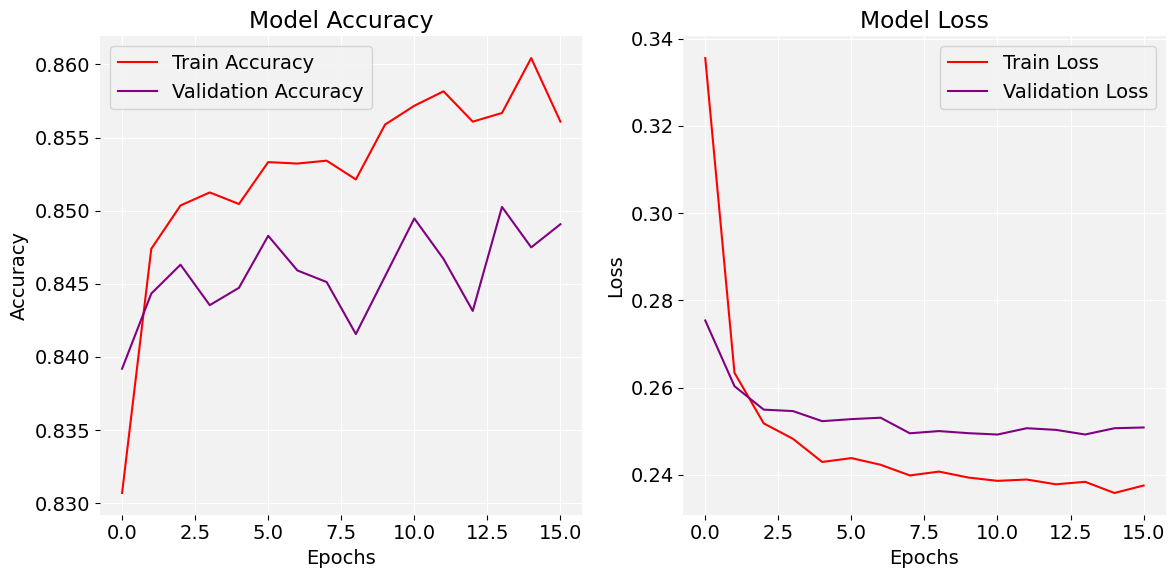

In [247]:
# Plotting the training and validation accuracy and loss
plt.figure(figsize=(12, 6))
plt.rcParams.update({
    'font.size': 14,
    'axes.facecolor': '#f2f2f2',  # Very light grey background
    'grid.color': 'white',
    'axes.edgecolor': '#f8f8f8',  # Removing border
    'axes.linewidth': 0.0
})

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], color='red', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], color='purple', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], color='red', label='Train Loss')
plt.plot(history.history['val_loss'], color='purple', label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.grid(True)

plt.tight_layout()
plt.show()

In [125]:
X_test_pred = X_test.copy()
X_test_pred['predicted'] = y_pred
X_test_pred['actual'] = y_test

X_test_pred['Max'] = X_test_pred.groupby('Job_ID')['predicted'].transform(lambda x: (x == x.max()).astype(int))
X_tt = X_test_pred[X_test_pred['actual'] == 1]

print(accuracy_score(X_test_pred['actual'], X_test_pred['Max']))
print(accuracy_score(X_tt['actual'], X_tt['Max']))

0.49861714737258
0.9202334630350194


## Test

In [193]:
X_test = matches_test_scaled.drop(['Match'], axis=1)

In [195]:
# Predict probabilities on the test set
y_pred = model.predict(X_test)

  1/125 [..............................] - ETA: 3s

125/125 [==============================] - 0s 2ms/step


In [196]:
X_test['prediction'] = y_pred

In [197]:
X_test.index.get_level_values(0).nunique()

800

In [198]:
X_test

prof_cat_exp_similarity  prof_cat_int_similarity  \
Job_ID   CANDIDATE_ID                                                     
1014_514 23262979                     1.789496                 0.344139   
         1482016                     -0.062095                -0.597146   
         83352824                     0.555102                 0.344139   
         54602123                     1.789496                 2.226710   
         92641837                    -0.062095                -0.597146   
...                                        ...                      ...   
9996_273 82724002                    -0.679291                -0.597146   
         38957146                    -0.679291                -0.032375   
         5137608                     -0.679291                -0.597146   
         39393438                    -0.679291                -0.597146   
         45683368                     0.555102                 0.344139   

                       hard_skills_similarity  soft_skills_similarity  \
Job_ID   CANDIDATE_ID                                                   
1014_514 23262979                    0.887062                -0.51756   
         1482016                    -0.564377                -0.51756   
         83352824                    2.990909                -0.51756   
         54602123                    0.887062                -0.51756   
         92641837                   -0.564377                -0.51756   
...                                       ...                     ...   
9996_273 82724002                    0.733830                -0.51756   
         38957146                   -0.564377                -0.51756   
         5137608                    -0.564377                -0.51756   
         39393438                   -0.564377                -0.51756   
         45683368                   -0.564377                -0.51756   

                       languages_similarity  cards_similarity  distance  \
Job_ID   CANDIDATE_ID                                                     
1014_514 23262979                  2.776838         -0.519310 -0.092271   
         1482016                   1.832306         -0.519310 -0.092271   
         83352824                 -0.447997         -0.519310 -0.054167   
         54602123                  2.776838         -0.519310 -0.055541   
         92641837                  1.413862         -0.519310 -0.033892   
...                                     ...               ...       ...   
9996_273 82724002                 -0.447997          1.426400 -0.117389   
         38957146                 -0.447997         -0.519310 -0.085699   
         5137608                  -0.447997          2.232339 -0.167453   
         39393438                 -0.447997          1.426400 -0.136425   
         45683368                 -0.447997          2.232339 -0.182602   

                       Education_similarity  overall_similarity  distance2  \
Job_ID   CANDIDATE_ID                                                        
1014_514 23262979                 -0.022366            0.582359  -0.045888   
         1482016                  -0.022366           -0.045517  -0.045888   
         83352824                 -0.022366            0.582359  -0.045495   
         54602123                 -0.022366            0.497398  -0.045512   
         92641837                 -0.022366           -0.269762  -0.045233   
...                                     ...                 ...        ...   
9996_273 82724002                 -0.022366            0.634500  -0.046077   
         38957146                 -0.022366           -0.903212  -0.045830   
         5137608                  -0.022366           -0.120247  -0.046283   
         39393438                 -0.022366            0.204067  -0.046181   
         45683368                 -0.022366            1.014652  -0.046301   

                       prediction  
Job_ID   CANDIDATE_ID              
1014_514 23262979        0.618107 

In [199]:
index_max = X_test.groupby(X_test.index.get_level_values(0))['prediction'].idxmax()
X_test['Max'] = 0
X_test.loc[index_max, 'Max'] = 1

In [200]:
X_test.groupby(X_test.index.get_level_values(0))['Max'].sum()

Job_ID
1014_514     1
101_663      1
1026_1577    1
102_3869     1
1044_9332    1
            ..
9963_1394    1
9965_4993    1
9980_5692    1
9982_5468    1
9996_273     1
Name: Max, Length: 800, dtype: int64

In [201]:
X_test_sub = X_test[X_test['Max'] == 1]
X_test_sub

,,prof_cat_exp_similarity,prof_cat_int_similarity,hard_skills_similarity,soft_skills_similarity,languages_similarity,cards_similarity,distance,Education_similarity,overall_similarity,distance2,prediction,Max
Job_ID,CANDIDATE_ID,,,,,,,,,,,,
1014_514,83352824,0.555102,0.344139,2.990909,-0.517560,-0.447997,-0.519310,-0.054167,-0.022366,0.582359,-0.045495,0.638060,1
101_663,9041634,0.555102,-0.597146,-0.564377,-0.517560,-0.447997,-0.519310,-0.166647,-0.022366,-0.903212,-0.046281,0.503321,1
1026_1577,57238440,1.789496,0.344139,1.949590,2.302857,-0.447997,0.856515,-0.188548,-0.022366,1.607861,-0.046303,0.536147,1
102_3869,12929256,1.789496,-0.597146,-0.564377,0.990016,-0.447997,-0.519310,-0.180014,-0.022366,-0.097548,-0.046300,0.586789,1
1044_9332,70656680,1.789496,-0.597146,-0.564377,-0.517560,-0.447997,-0.519310,-0.173164,-0.022366,-0.903212,-0.046292,0.574584,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9963_1394,28215167,0.555102,-0.597146,-0.564377,-0.517560,-0.447997,-0.519310,-0.163185,-0.022366,-0.903212,-0.046274,0.503376,1
9965_4993,71248428,0.555102,-0.597146,-0.564377,0.743768,2.776838,-0.519310,-0.188548,-0.022366,0.087169,-0.046303,0.524201,1
9980_5692,1899259,1.789496,0.344139,-0.564377,-0.517560,-0.447997,-0.519310,-0.166162,-0.022366,-0.903212,-0.046281,0.511224,1


In [202]:
X_test_sub[X_test_sub.index.get_level_values(0) == '6954_6795']

prof_cat_exp_similarity  prof_cat_int_similarity  \
Job_ID    CANDIDATE_ID                                                     
6954_6795 43343785                     1.789496                 0.108818   
          43343785                     1.789496                 0.108818   

                        hard_skills_similarity  soft_skills_similarity  \
Job_ID    CANDIDATE_ID                                                   
6954_6795 43343785                    0.779395                1.875643   
          43343785                    0.779395                1.875643   

                        languages_similarity  cards_similarity  distance  \
Job_ID    CANDIDATE_ID                                                     
6954_6795 43343785                   1.16442          -0.51931  0.242734   
          43343785                   1.16442          -0.51931  0.242734   

                        Education_similarity  overall_similarity  distance2  \
Job_ID    CANDIDATE_ID                                                        
6954_6795 43343785                 -0.022366             1.08989  -0.037986   
          43343785                 -0.022366             1.08989  -0.037986   

                        prediction  Max  
Job_ID    CANDIDATE_ID                   
6954_6795 43343785        0.575103    1  
          43343785        0.575103    1

In [203]:
xx = X_test_sub.reset_index()

In [204]:
xx

,Job_ID,CANDIDATE_ID,prof_cat_exp_similarity,prof_cat_int_similarity,hard_skills_similarity,soft_skills_similarity,languages_similarity,cards_similarity,distance,Education_similarity,overall_similarity,distance2,prediction,Max
0,1014_514,83352824,0.555102,0.344139,2.990909,-0.517560,-0.447997,-0.519310,-0.054167,-0.022366,0.582359,-0.045495,0.638060,1
1,101_663,9041634,0.555102,-0.597146,-0.564377,-0.517560,-0.447997,-0.519310,-0.166647,-0.022366,-0.903212,-0.046281,0.503321,1
2,1026_1577,57238440,1.789496,0.344139,1.949590,2.302857,-0.447997,0.856515,-0.188548,-0.022366,1.607861,-0.046303,0.536147,1
3,102_3869,12929256,1.789496,-0.597146,-0.564377,0.990016,-0.447997,-0.519310,-0.180014,-0.022366,-0.097548,-0.046300,0.586789,1
4,1044_9332,70656680,1.789496,-0.597146,-0.564377,-0.517560,-0.447997,-0.519310,-0.173164,-0.022366,-0.903212,-0.046292,0.574584,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,9963_1394,28215167,0.555102,-0.597146,-0.564377,-0.517560,-0.447997,-0.519310,-0.163185,-0.022366,-0.903212,-0.046274,0.503376,1
797,9965_4993,71248428,0.555102,-0.597146,-0.564377,0.743768,2.776838,-0.519310,-0.188548,-0.022366,0.087169,-0.046303,0.524201,1
798,9980_5692,1899259,1.789496,0.344139,-0.564377,-0.517560,-0.447997,-0.519310,-0.166162,-0.022366,-0.903212,-0.046281,0.511224,1
799,9982_5468,82491379,0.555102,0.344139,1.488268,-0.517560,-0.447997,-0.519310,0.419353,-0.022366,0.204067,-0.029779,0.523786,1


In [205]:
job_id_list_test = pd.read_csv('job_id_list_test.txt', header=None)

In [206]:
job_id_list_test

,0
0,2482_927
1,1310_19
2,8405_1436
3,6233_483
4,8105_8908
...,...
795,1728_8760
796,4803_9951
797,4719_5184
798,3999_3695


In [207]:
final = pd.merge(job_id_list_test, xx, left_on=0, right_on='Job_ID', how='left')
final

,0,Job_ID,CANDIDATE_ID,prof_cat_exp_similarity,prof_cat_int_similarity,hard_skills_similarity,soft_skills_similarity,languages_similarity,cards_similarity,distance,Education_similarity,overall_similarity,distance2,prediction,Max
0,2482_927,2482_927,64595902,1.789496,-0.597146,2.990909,2.302857,-0.447997,-0.519310,-0.135636,-0.022366,2.228646,-0.046178,0.703046,1
1,1310_19,1310_19,4824920,1.789496,-0.597146,-0.564377,-0.517560,1.832306,-0.519310,-0.123622,-0.022366,-0.202907,-0.046114,0.598643,1
2,8405_1436,8405_1436,84114500,0.555102,-0.597146,1.949590,2.302857,-0.447997,-0.519310,-0.168668,-0.022366,1.809057,-0.046285,0.499044,1
3,6233_483,6233_483,55096946,1.789496,0.814782,-0.564377,-0.517560,-0.447997,-0.519310,-0.095272,-0.022366,-0.903212,-0.045914,0.498017,1
4,8105_8908,8105_8908,25162353,0.143638,-0.597146,1.025595,-0.517560,1.413862,-0.519310,-0.175957,-0.022366,0.262166,-0.046296,0.543120,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,1728_8760,1728_8760,1999789,1.789496,-0.597146,0.507582,2.141554,1.413862,1.426400,-0.085031,-0.022366,1.296729,-0.045824,0.613596,1
797,4803_9951,4803_9951,11512982,1.789496,-0.597146,-0.564377,-0.517560,-0.447997,-0.519310,-0.145211,-0.022366,-0.903212,-0.046219,0.575629,1
798,4719_5184,4719_5184,79287820,0.143638,-0.597146,-0.564377,1.110808,-0.447997,-0.519310,-0.170661,-0.022366,0.375364,-0.046289,0.472679,1
799,3999_3695,3999_3695,24714973,0.555102,-0.597146,-0.564377,-0.517560,-0.447997,2.232339,-0.170144,-0.022366,0.757707,-0.046288,0.502295,1


In [208]:
final[final.duplicated(subset=[0])]

,0,Job_ID,CANDIDATE_ID,prof_cat_exp_similarity,prof_cat_int_similarity,hard_skills_similarity,soft_skills_similarity,languages_similarity,cards_similarity,distance,Education_similarity,overall_similarity,distance2,prediction,Max
146,6954_6795,6954_6795,43343785,1.789496,0.108818,0.779395,1.875643,1.16442,-0.51931,0.242734,-0.022366,1.08989,-0.037986,0.575103,1


In [209]:
ff = final.drop_duplicates(subset=[0])

In [210]:
ff

,0,Job_ID,CANDIDATE_ID,prof_cat_exp_similarity,prof_cat_int_similarity,hard_skills_similarity,soft_skills_similarity,languages_similarity,cards_similarity,distance,Education_similarity,overall_similarity,distance2,prediction,Max
0,2482_927,2482_927,64595902,1.789496,-0.597146,2.990909,2.302857,-0.447997,-0.519310,-0.135636,-0.022366,2.228646,-0.046178,0.703046,1
1,1310_19,1310_19,4824920,1.789496,-0.597146,-0.564377,-0.517560,1.832306,-0.519310,-0.123622,-0.022366,-0.202907,-0.046114,0.598643,1
2,8405_1436,8405_1436,84114500,0.555102,-0.597146,1.949590,2.302857,-0.447997,-0.519310,-0.168668,-0.022366,1.809057,-0.046285,0.499044,1
3,6233_483,6233_483,55096946,1.789496,0.814782,-0.564377,-0.517560,-0.447997,-0.519310,-0.095272,-0.022366,-0.903212,-0.045914,0.498017,1
4,8105_8908,8105_8908,25162353,0.143638,-0.597146,1.025595,-0.517560,1.413862,-0.519310,-0.175957,-0.022366,0.262166,-0.046296,0.543120,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,1728_8760,1728_8760,1999789,1.789496,-0.597146,0.507582,2.141554,1.413862,1.426400,-0.085031,-0.022366,1.296729,-0.045824,0.613596,1
797,4803_9951,4803_9951,11512982,1.789496,-0.597146,-0.564377,-0.517560,-0.447997,-0.519310,-0.145211,-0.022366,-0.903212,-0.046219,0.575629,1
798,4719_5184,4719_5184,79287820,0.143638,-0.597146,-0.564377,1.110808,-0.447997,-0.519310,-0.170661,-0.022366,0.375364,-0.046289,0.472679,1
799,3999_3695,3999_3695,24714973,0.555102,-0.597146,-0.564377,-0.517560,-0.447997,2.232339,-0.170144,-0.022366,0.757707,-0.046288,0.502295,1
